<a href="https://colab.research.google.com/github/p25-c4/plate_project/blob/main/scale_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!rm ~/.cache/matplotlib -rf

Selecting previously unselected package fonts-nanum.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [1]:
# 데이터 구성:Series, DataFrame
import pandas as pd
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split

# Standard Scaling
from sklearn.preprocessing import StandardScaler

# 분류 Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# 팔레트 설정
palette = sns.color_palette('Paired')
colors = sns.color_palette('Pastel1')
sns.set_palette('Pastel1')


In [2]:
import matplotlib as mpl
# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'
# 그래프 (-) 기호 표시
matplotlib.rc("axes", unicode_minus = False)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 데이터 불러오기
df_raw = pd.read_csv("/content/drive/MyDrive/BigData/real_final_scale.csv")
df_raw.head()

,scale,spec_country,steel_kind,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,day_yn,purpose
0,0,미국,T,32,3700,15100,1,1,1144,116,1133,59,259,TMCP(온도제어),934,8,주간,선체구조용(조선용)
1,0,미국,T,32,3700,15100,1,2,1144,122,1135,53,238,TMCP(온도제어),937,8,주간,선체구조용(조선용)
2,0,영국,T,33,3600,19200,2,1,1129,116,1121,55,258,TMCP(온도제어),889,8,주간,선체구조용(조선용)
3,0,영국,T,33,3600,19200,2,2,1152,125,1127,68,266,TMCP(온도제어),885,8,주간,선체구조용(조선용)
4,0,프랑스,T,38,3100,13300,3,1,1140,134,1128,48,246,TMCP(온도제어),873,8,주간,선체구조용(조선용)


In [5]:
df_raw['fur_no'] = df_raw['fur_no'].astype(str)
df_raw['fur_input_row'] = df_raw['fur_input_row'].astype(str)
# df_raw['descaling_count'] = df_raw['descaling_count'].apply(lambda x: 'odd' if x % 2 != 0 else str(x))  # 홀수는 'odd', 짝수는 문자열로 범주화

In [6]:
df_raw_x = df_raw.drop('scale', axis=1)
df_raw_x_1 = df_raw.drop(["scale",'steel_kind', 'day_yn', 'rolling_method'], axis=1)
df_raw_x_2 = df_raw[['steel_kind', 'day_yn', 'rolling_method']]  # 범주가 2개인 자료는 따로 dummy화
df_raw_y = df_raw['scale']

In [7]:
# 범주형 변수 선택 : select_dtypes="object"
df_raw_x_char_1 = df_raw_x_1.select_dtypes(include = "object")
df_raw_x_char_2 = df_raw_x_2.select_dtypes(include = "object")
df_raw_x_char = pd.concat([df_raw_x_char_1, df_raw_x_char_2], axis=1)

# get_dummies: 범주형 변수에 대한 더미변환
df_x_dummy_1 = pd.get_dummies(df_raw_x_char_1)
df_x_dummy_2 = pd.get_dummies(df_raw_x_char_2, drop_first=True) # 범주가 2개인 자료는 따로 dummy화
df_x_dummy = pd.concat([df_x_dummy_1, df_x_dummy_2], axis=1)


# 연속형 변수 선택 : select_dtypes="object" 제외
df_raw_x_num = df_raw_x.select_dtypes(exclude = "object")

# 변수명 저장
v_feature_names = df_raw_x_num.columns

# StandardScaler 적용
scaler = StandardScaler()
df_x_scaled = scaler.fit_transform(df_raw_x_num)
df_x_scaled = pd.DataFrame(df_x_scaled, columns=v_feature_names)

# 원래 연속형(df_raw_x_num) + dummy된 범주형(df_x_dummy)
df_x_raw_dummy = df_raw_x_num.join(df_x_dummy)
display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:",df_x_raw_dummy.head(3))

# scale된 연속형(df_x_scaled)+ dummy된 범주형(df_x_dummy)
df_x_scale_dummy = df_x_scaled.join(df_x_dummy)
display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:",df_x_scale_dummy.head(3))

# scale된 연속형(df_x_scaled) + 원래 범주형(df_raw_x_char)
df_x_scale_raw = df_x_scaled.join(df_raw_x_char)
display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_x_scale_raw.head(3))

'원래 연속형+ Dummied 범주형...DT/RF/GB 용:'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,...,fur_no_3,fur_input_row_1,fur_input_row_2,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
0,32,3700,15100,1144,116,1133,59,259,934,8,...,0,1,0,0,1,0,0,1,1,1
1,32,3700,15100,1144,122,1135,53,238,937,8,...,0,0,1,0,1,0,0,1,1,1
2,33,3600,19200,1129,116,1121,55,258,889,8,...,0,1,0,0,1,0,0,1,1,1


'Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,...,fur_no_3,fur_input_row_1,fur_input_row_2,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
0,0.298839,1.765880,-1.561273,-0.623951,1.13104,-1.034421,-0.615879,0.534990,-0.103218,-0.342411,...,0,1,0,0,1,0,0,1,1,1
1,0.298839,1.765880,-1.561273,-0.623951,1.35857,-0.918753,-0.906940,-0.017416,-0.056516,-0.342411,...,0,0,1,0,1,0,0,1,1,1
2,0.354957,1.562785,-1.265674,-1.333010,1.13104,-1.728433,-0.809920,0.508684,-0.803747,-0.342411,...,0,1,0,0,1,0,0,1,1,1


'Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,spec_country,fur_no,fur_input_row,purpose,steel_kind,day_yn,rolling_method
0,0.298839,1.765880,-1.561273,-0.623951,1.13104,-1.034421,-0.615879,0.534990,-0.103218,-0.342411,미국,1,1,선체구조용(조선용),T,주간,TMCP(온도제어)
1,0.298839,1.765880,-1.561273,-0.623951,1.35857,-0.918753,-0.906940,-0.017416,-0.056516,-0.342411,미국,1,2,선체구조용(조선용),T,주간,TMCP(온도제어)
2,0.354957,1.562785,-1.265674,-1.333010,1.13104,-1.728433,-0.809920,0.508684,-0.803747,-0.342411,영국,2,1,선체구조용(조선용),T,주간,TMCP(온도제어)


In [8]:
## train_test_split
# 원래 연속형+ Dummied 범주형...DT/RF/GB 용:df_x_raw_dummy
df_train_x_rd, df_test_x_rd, df_train_y, df_test_y = train_test_split(df_x_raw_dummy, df_raw_y
                                    , test_size = 0.3, stratify = df_x_raw_dummy["steel_kind_T"], random_state=2024)

display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:", df_train_x_rd.head())

# # 기계학습용 데이터(Scaled 연속형+ Dummied 범주형) 분할:df_x_scale_dummy
# df_train_x_sd, df_test_x_sd, df_train_y, df_test_y = train_test_split(df_x_scale_dummy, df_raw_y
#                                     , test_size = 0.2, stratify = df_x_raw_dummy["steel_kind_T"], random_state=2024)

# display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:", df_train_x_sd.head())

# # 회귀분석용(표준화 회귀계수) 데이터(Scaled 연속형+ 원래 범주형) 분할:df_x_scale_raw
# df_train_x_reg, df_test_x_reg, df_train_y, df_test_y = train_test_split(df_x_scale_raw, df_raw_y
#                                     , test_size = 0.2, stratify = df_x_raw_dummy["steel_kind_T"], random_state=2024)

# display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_train_x_reg.head())

'원래 연속형+ Dummied 범주형...DT/RF/GB 용:'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,...,fur_no_3,fur_input_row_1,fur_input_row_2,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
565,81,2900,9800,1139,132,1124,80,287,877,6,...,0,0,1,1,0,0,0,1,1,0
771,26,2600,31300,1165,73,1160,63,223,1026,8,...,0,1,0,1,0,0,0,0,0,0
46,51,3100,12400,1133,57,1125,103,238,862,6,...,1,1,0,0,1,0,0,1,1,1
703,19,2700,54300,1178,69,1165,57,227,1005,10,...,1,1,0,0,1,0,0,0,1,0
457,14,2900,54300,1166,72,1163,60,221,923,10,...,1,1,0,0,0,1,0,0,1,0


# 모델 생성(xgboost)

### 기본 옵션 모델

In [9]:
# !pip install xgboost

In [10]:
# xgboost 패키지 불러오기
from xgboost import XGBClassifier

# 변수 중요도 확인: F1 점수 기준
from xgboost import plot_importance

# 분류모델 통합 평가: 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 등
def eval_class_model(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)

    print('오차행렬:\n', confusion, '\n')
    print('정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1    : {:.4f}'.format(F1))
    print('AUC   : {:.4f}'.format(AUC))

In [11]:
# 기본 모델 지정 및 기본 옵션 확인
xgboost_uncust = XGBClassifier()
xgboost_uncust.fit(df_train_x_rd,df_train_y)
print('\n 모델 생성 및 평가 : Train \n')

# 예측 및 모델 평가:train
xgb_pred_train = xgboost_uncust.predict(df_train_x_rd)
# 모델 평가
eval_class_model(df_train_y, xgb_pred_train)

print('\n 모델 생성 및 평가 : Test \n')
# 예측 및 모델 평가:test
xgb_pred_test = xgboost_uncust.predict(df_test_x_rd)
# 모델 평가
eval_class_model(df_test_y, xgb_pred_test)


 모델 생성 및 평가 : Train 

오차행렬:
 [[482   0]
 [  0 180]] 

정확도: 1.0000
정밀도: 1.0000
재현율: 1.0000
F1    : 1.0000
AUC   : 1.0000

 모델 생성 및 평가 : Test 

오차행렬:
 [[202   0]
 [  3  80]] 

정확도: 0.9895
정밀도: 1.0000
재현율: 0.9639
F1    : 0.9816
AUC   : 0.9819


### 사용자 정의 모델(hyper parameter tuning)

#### learning_rate

In [12]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# learning_rate 학습률 변경
para_lr = [lr * 0.01 for lr in range(1, 10)]   # 민감하게 변화하면 0.02 간격으로 확인

for v_learning_rate in para_lr:
    gb = XGBClassifier(learning_rate = v_learning_rate)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr["LearningRate"] = para_lr
df_accuracy_lr["TrainAccuracy"] = train_accuracy
df_accuracy_lr["TestAccuracy"] = test_accuracy

In [13]:
# LearningRate별 정확도
df_accuracy_lr.round(3)

,LearningRate,TrainAccuracy,TestAccuracy
0,0.01,0.985,0.979
1,0.02,0.992,0.982
2,0.03,0.994,0.982
3,0.04,0.994,0.986
4,0.05,0.994,0.986
5,0.06,0.995,0.986
6,0.07,0.997,0.986
7,0.08,0.997,0.986
8,0.09,0.998,0.986


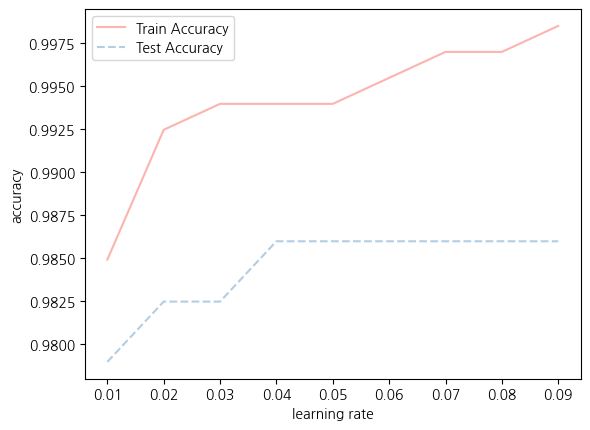

In [14]:
# LearningRate별 정확도 그래프 확인
plt.plot(para_lr, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("learning rate")
plt.legend()

- learning_rate = 0.04
    - train accuarcy와 test accuracy의 차이가 적고
    - test accuarcy가 떨어지기 전인 lr=0.03 선택

#### n_estimators

In [15]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    gb = XGBClassifier(n_estimators = v_n_estimators, learning_rate=0.04)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["Estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

In [16]:
# n_estimators별 정확도
df_accuracy_n.round(3)

,Estimators,TrainAccuracy,TestAccuracy
0,10,0.923,0.909
1,20,0.985,0.979
2,30,0.985,0.979
3,40,0.988,0.979
4,50,0.992,0.982
5,60,0.994,0.982
6,70,0.994,0.982
7,80,0.994,0.986
8,90,0.994,0.986
9,100,0.994,0.986


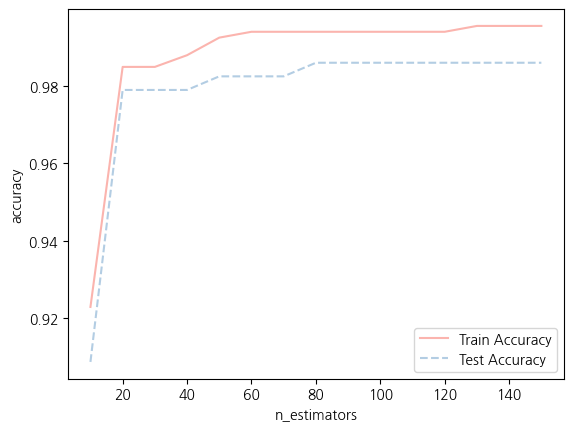

In [17]:
# 정확도를 그래프 확인
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_estimators")
plt.legend()

- n_estimators = 100
    - 20부터 120까지 train accuracy와 test accuracy가 비슷하지만
    - lr이 작으므로 적당히 큰 n_estimators = 100 선택

#### max_depth

In [18]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경. 1~10
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = XGBClassifier(max_depth = v_max_depth,
                            n_estimators=100, learning_rate=0.04)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

In [19]:
# max_depth별 정확도
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.962,0.947
1,2,0.962,0.947
2,3,0.986,0.968
3,4,0.992,0.986
4,5,0.994,0.986
5,6,0.994,0.986
6,7,0.994,0.986
7,8,0.994,0.986
8,9,0.994,0.986
9,10,0.994,0.986


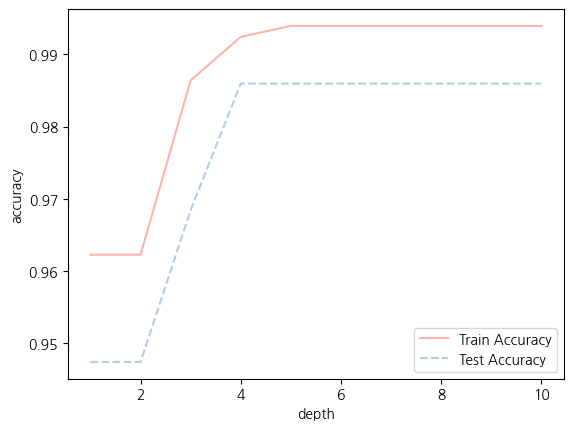

In [20]:
# 정확도를 그래프 확인
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("depth")
plt.legend()

- max_depth = 5
    - max 값이므로 여유있게 max_depth = 5로 선택

In [21]:
xgb_custom = XGBClassifier(max_depth = 5, n_estimators=100, learning_rate=0.04)

# 모델 적합
xgb_custom.fit(df_train_x_rd, df_train_y)

# 예측 및 모델 평가:Train
xgb_pred_train = xgb_custom.predict(df_train_x_rd)

print('\n 사용자 모델 평가 : Train \n')
eval_class_model(df_train_y, xgb_pred_train)
print('\n',classification_report(df_train_y, xgb_pred_train))


# 예측 및 모델 평가:Test
xgb_pred_test = xgb_custom.predict(df_test_x_rd)

print('\n 사용자 모델 평가 : Test \n')
eval_class_model(df_test_y, xgb_pred_test)
print('\n',classification_report(df_test_y, xgb_pred_test))


 사용자 모델 평가 : Train 

오차행렬:
 [[482   0]
 [  4 176]] 

정확도: 0.9940
정밀도: 1.0000
재현율: 0.9778
F1    : 0.9888
AUC   : 0.9889

               precision    recall  f1-score   support

           0       0.99      1.00      1.00       482
           1       1.00      0.98      0.99       180

    accuracy                           0.99       662
   macro avg       1.00      0.99      0.99       662
weighted avg       0.99      0.99      0.99       662


 사용자 모델 평가 : Test 

오차행렬:
 [[202   0]
 [  4  79]] 

정확도: 0.9860
정밀도: 1.0000
재현율: 0.9518
F1    : 0.9753
AUC   : 0.9759

               precision    recall  f1-score   support

           0       0.98      1.00      0.99       202
           1       1.00      0.95      0.98        83

    accuracy                           0.99       285
   macro avg       0.99      0.98      0.98       285
weighted avg       0.99      0.99      0.99       285



In [22]:
# estimator = XGBClassifier()
# # 구하고자 하는 parameter와 범위
# param_grid = {"learning_rate": para_lr,
#               "max_depth": para_depth,
#               "n_estimators": [200, 250, 300],
#               "gamma": [0, 1, 2]}
# # 정확도가 높은 최적 parameter 찾기
# grid_xgb = GridSearchCV(estimator, param_grid, scoring="f1", n_jobs = -1)
# grid_xgb.fit(df_train_x_rd, df_train_y)
# print("best estimator model: \n{}".format(grid_xgb.best_estimator_))
# print("\nbest parameter: \n{}".format(grid_xgb.best_params_))
# print("\nbest score: \n{}".format(grid_xgb.best_score_.round(3)))

In [24]:
# 모델 적합
grid_best = XGBClassifier(gamma=0, learning_rate=0.05, max_depth=3, n_estimators=250)
grid_best.fit(df_train_x_rd, df_train_y)

# 예측 및 모델 평가:Train
xgb_pred_train = grid_best.predict(df_train_x_rd)

print('\n 사용자 모델 평가 : Train \n')
eval_class_model(df_train_y, xgb_pred_train)
print('\n',classification_report(df_train_y, xgb_pred_train))


# 예측 및 모델 평가:Test
xgb_pred_test = grid_best.predict(df_test_x_rd)

print('\n 사용자 모델 평가 : Test \n')
eval_class_model(df_test_y, xgb_pred_test)
print('\n',classification_report(df_test_y, xgb_pred_test))


 사용자 모델 평가 : Train 

오차행렬:
 [[482   0]
 [  2 178]] 

정확도: 0.9970
정밀도: 1.0000
재현율: 0.9889
F1    : 0.9944
AUC   : 0.9944

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       482
           1       1.00      0.99      0.99       180

    accuracy                           1.00       662
   macro avg       1.00      0.99      1.00       662
weighted avg       1.00      1.00      1.00       662


 사용자 모델 평가 : Test 

오차행렬:
 [[202   0]
 [  4  79]] 

정확도: 0.9860
정밀도: 1.0000
재현율: 0.9518
F1    : 0.9753
AUC   : 0.9759

               precision    recall  f1-score   support

           0       0.98      1.00      0.99       202
           1       1.00      0.95      0.98        83

    accuracy                           0.99       285
   macro avg       0.99      0.98      0.98       285
weighted avg       0.99      0.99      0.99       285



- grid search 결과를 최종 모델로 선정
    - test set에 대한 f1-score와 accuracy는 비슷하지만
    - Cross Validatio을 거쳤으므로 더 안정성이 있다고 생각.

In [25]:
# 최종 모델 이름
xgb_final = grid_best
# best parameter:
# {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 250}

### 설명변수 중요도

In [36]:
# 변수명
v_feature_name = df_train_x_rd.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_name
df_importance ["Importance"] = gb_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance10 = df_importance.head(10)
df_importance10 .round(3)

,Feature,Importance
8,rolling_temp,0.434
5,fur_soak_temp,0.249
0,pt_thick,0.070
9,descaling_count,0.064
2,pt_length,0.030
7,fur_total_time,0.022
6,fur_soak_time,0.018
11,spec_country_독일,0.017
13,spec_country_영국,0.017
19,fur_no_3,0.015


<ipython-input-46-88c191b2db6f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_importance10 .sort_values("Importance", ascending=True, inplace = True)


Text(0, 0.5, '설명변수')

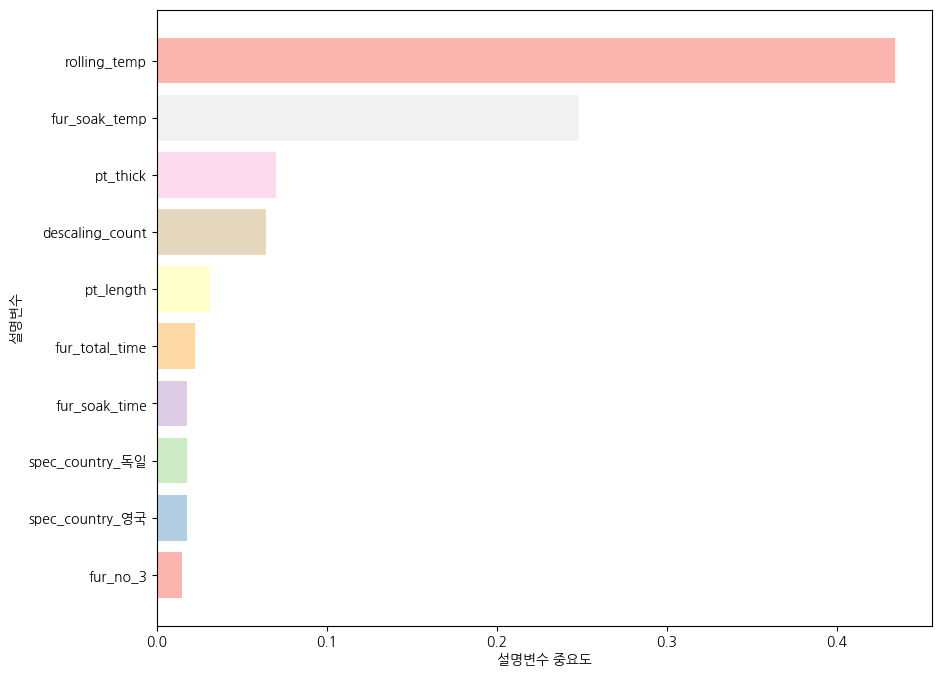

In [46]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위 10개 그림

palette = sns.color_palette("Pastel1", len(df_importance10))
fig, ax = plt.subplots(figsize=(10, 8))

df_importance10 .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance10 ))
plt.barh(y = coordinates, width = df_importance10 ["Importance"],color = palette )
plt.yticks(coordinates, df_importance10 ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

- rolling_temp, fur_soak_temp, pt_thick, descaling_count 순서로 중요하다.